# Projet Fil Rouge 2022 : Reconnaissance de commandes audio
---


**Noms :** EL MOUSTAAID

**Prénoms :** MOUNTASSIR

**Nom du binôme :** NGUYEN Xuan Minh Vuong




**Objectif** : tester l'algorithme de programmation dynamique vu en CTD et réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="./DroneJS.jpg" width="600" height="500"  >


- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa, math
from os.path import isfile, join
from os import listdir
import os, sys, random
import pandas as pd
import torch

random.seed(0)
np.random.seed(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Préparation du jeu de données
---

Sur l'espace moodle de l'ENSEEIHT, nous trouvons un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond à la dimension du vecteur représentatif : ici 12.



### Prétraitement sur 1 fichier audio

In [3]:
# path to the dataset
datapath = join('.', 'data')

# the first audio file
filename = listdir(datapath)[0]
filepath = join(datapath, filename)

**Calcul des MFCC**

 Pour chaque enregistrement audio, calculez le vecteur de  $\mathbb{R}^{12}$  égal à la moyenne sur toutes les fenêtres de MFCC. Ainsi chaque enregistrement sera représenté par un seul vecteur de 12 coefficients MFCC.

In [4]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path)
    return audio, sr

def compute_mfcc(audio, sampling_rate, n_mfcc = 12):
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, hop_length=1024, htk=True, n_mfcc = n_mfcc)
    return mfcc

def plot_audio(audio, fig_title = 'Signal audio'):
    if torch.is_tensor(audio):
        audio = np.squeeze(audio.numpy())
    plt.plot(audio)
    plt.title(fig_title)
    plt.show()

def plot_mfcc(mfcc, fig_title = 'mfcc'):
    _, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(10,5))
    ax1.plot(mfcc)
    ax2.imshow(mfcc)
    plt.title(fig_title)
    plt.show()

def plot_audio_mfcc(audio, mfcc):
    fig = plt.figure(figsize = (10,5))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1.plot(audio)
    ax1.set_title('Signal audio')

    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax2.plot(mfcc)
    ax2.set_title('mfcc')

    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    ax3.imshow(mfcc)
    ax3.set_title('mfcc')
    plt.show()


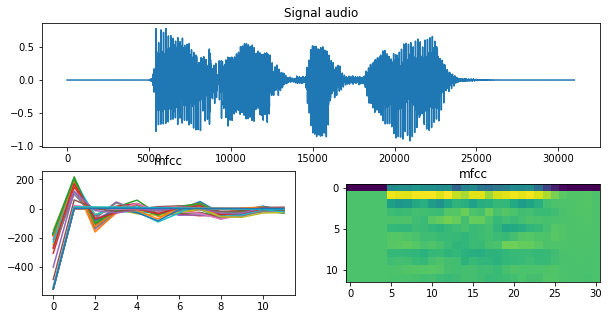

In [5]:
# load audio
audio, sr = load_audio(filepath)

# compute mfcc
mfcc = compute_mfcc(audio, sr)

# visualize audio & mfcc
plot_audio_mfcc(audio, mfcc)

### Définition de la dimension à extraire  
Les enregistrements étant de durées différentes, il faut pouvoir comparer les données entre elles et donc procéder à un fenêtrage du signal.

In [6]:
Nb_SegmentMFCC = 12
Nb_SegmentSignal = 1000

In [7]:
# Fonction permettant de discrétiser le signal ou les mfcc, noté y, en Nb_segment 
# sur chaque fenêtre une statistique (moyenne, minimum ou maximum...) est extraite
def ReductionMemeDimension(y,Nb_Segment, n_mfcc = 12):
    Taille_y = len(y)
    Nouvelle_donnees= np.zeros((Nb_Segment,1))
    Nb_FenetreParSegment= math.floor(Taille_y/Nb_Segment)

    for i in range(0,Nb_Segment):
        if len(y)==n_mfcc:
            Nouvelle_donnees[i] = np.mean(y[:,i*Nb_FenetreParSegment:(i+1)*Nb_FenetreParSegment])
        else : 
            Nouvelle_donnees[i] = np.max(y[i*Nb_FenetreParSegment:(i+1)*Nb_FenetreParSegment])

    return Nouvelle_donnees

In [8]:
# Test sur les mfcc et le signal à partir d'un fichier audio
DataMFCCReduc = ReductionMemeDimension(mfcc,Nb_SegmentMFCC)
DataSignalReduc = ReductionMemeDimension(audio,Nb_SegmentSignal)

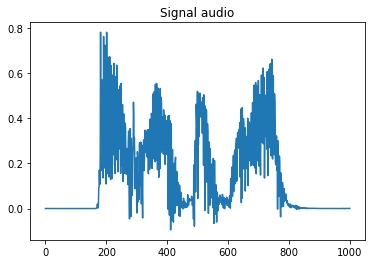

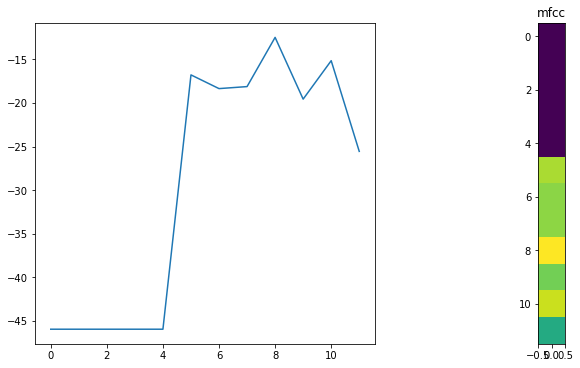

In [9]:
# Affichage de l'extraction 
plot_audio(audio = DataSignalReduc)
plot_mfcc(mfcc = DataMFCCReduc)


## Création de la base d'apprentissage et de test 

Nous allons utilisé tout les enregistrements audio.

Nous avons donc recopié tout les enregistrements dans le même dossier **data**.

In [10]:
def bar_plot(data_path):
    """_summary_
    Args:
        data_path (_type_): _description_

    Returns:
        _type_: _description_
    """
    # the files within the new dataset
    fichiers = os.listdir(data_path)

    # the classes within the new dataset
    all_classes = []
    try:
        for fname in fichiers:
            name = fname.split('.')[0]
            label = name.split('_')[-1]
            all_classes.append(label)
    except:
        print('Exception ', sys.exc_info()[0], ' occured!')


    # plot the bars
    pd.Series(all_classes).value_counts().plot(kind = 'bar')


    # get list of unique classes
    all_classes = list(set(all_classes))
    print('Nous avons les classes suivantes : ')
    print(all_classes)
    return all_classes

Nous avons les classes suivantes : 
['etatdurgence', 'atterrissage', 'decollage', 'gauche', 'plusbas', 'plushaut', 'droite', 'arretetoi', 'tournegauche', 'recule', 'avance', 'faisunflip', 'tournedroite']


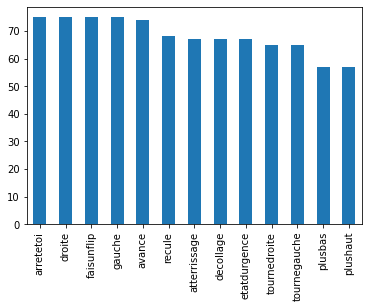

In [11]:
all_classes = bar_plot(datapath)

Dans un premier temps, nous nous limitons à trois classes, notre objectif est de comparer les approches.

Les classes à garder sont :
* avance
* recule
* tournegauche

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

In [13]:
def load_data(datapath, classes, test_percent):
    """_summary_

    Args:
        datapath (_type_): _description_
        classes (_type_): _description_
        test_percent (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Get file names and sort them in order to have the same order
    # no matter what OS you are using
    fichiers = sorted(listdir(datapath))
    fichiers = np.array(fichiers)

    # get the label corresponding to each file
    # and filter the files, only keep the ones with a class 
    # belonging to the list classes
    labels = []
    fichiers_filtre = []
    for fname in fichiers:
        name, extension = fname.split('.')
        name, label = name.split('_')
        if label in classes:
            fichiers_filtre.append(fname)
            labels.append(classes.index(label))
    labels = np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size= test_percent, random_state=0)
    for train_index, test_index in sss.split(fichiers_filtre, labels):
        # just to get the train_index and test_index lists
        ListBaseApp = np.array(train_index)
        ListBaseTest = np.array(test_index)

    nbvalApp = len(ListBaseApp)
    nbvalTest = len(ListBaseTest)

    # Formattage des labels
    LabelApp = np.ravel(labels[ListBaseApp])
    LabelTest = np.ravel(labels[ListBaseTest])

    # Calcul des MFCC sur tous les fichiers de la base d'apprentissage
    BaseApp=[]
    BaseTest=[]
    for i in range(len(ListBaseApp)):
        audio, sr = load_audio(join(datapath, fichiers_filtre[ListBaseApp[i]]))
        mfccBA = compute_mfcc(audio, sr)
        mfccBAReduc=ReductionMemeDimension(mfccBA,Nb_SegmentMFCC)
        BaseApp.append(mfccBAReduc)

    for i in range(len(ListBaseTest)):
        audio, sr = load_audio(join(datapath, fichiers_filtre[ListBaseTest[i]]))
        mfccBT = compute_mfcc(audio, sr)
        mfccBTReduc=ReductionMemeDimension(mfccBT,Nb_SegmentMFCC)
        BaseTest.append(mfccBTReduc)
    

    BaseApp=np.asarray(BaseApp)
    BaseTest=np.asarray(BaseTest)
    BaseApp=np.reshape(BaseApp,(nbvalApp,Nb_SegmentMFCC))
    BaseTest=np.reshape(BaseTest,(nbvalTest,Nb_SegmentMFCC))

    return BaseApp, BaseTest, LabelApp, LabelTest


In [14]:
classes = ['avance','recule', 'tournegauche']
test_percent = 0.2
BaseApp, BaseTest, LabelApp, LabelTest = load_data(datapath, classes, test_percent)

Voyons à quoi ressemble notre jeu de données d'entrainement

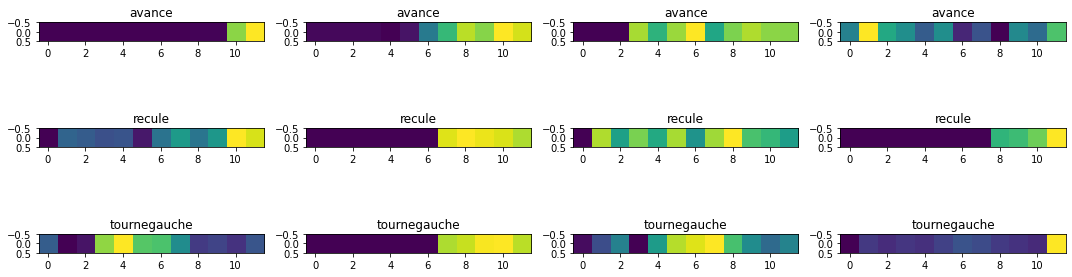

In [15]:
fig = plt.figure(figsize = (15,5))
for label_idx, label_name in enumerate(classes):
    indices = (LabelApp == label_idx)
    data = BaseApp[indices]
    for i in range(4):
        mfcc = data[i]
        mfcc_formated = np.reshape(mfcc, newshape = (12,1)).transpose()
        ax = plt.subplot(3, 4, (i+1) + 4*label_idx)
        ax.imshow(mfcc_formated)
        ax.set_title(label_name)
        #ax.set_axis_off()
plt.tight_layout()
plt.show()

# Partie I : Sélection de modèles et pénalisation

### 1. Régression Multiclasse

Appliquer un modèle de **régression multiclasses**.

On modélise les probabilités par la forme suivante :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } { 1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
Pour tout $j$ dans $\{ 1,2, \dots , K-1 \}$.

On peut aussi considérer un modèle binomiale par classe pour l'analyse. i.e (Considérer les labels dans la classe $k$ comme étant 1 et les autres labels 0)

Pour votre étude, On vous proposera les comparaisons suivantes (liste exhaustive) : 

1. Essayer différents type d'optimiseurs disponibles dans la librairie Sklearn (lbfgs, saga, sag, newton-cg) et comparer la vitesse de convergence.

2. Faire varier le coefficient de régularisation $C$ (<span style="color:red"> **Il y a toujours une régularisation par défaut dans sklearn** </span>) et comparer son effet sur la performance.

3. Modèle binomiale versus Régression multinomiale. 

4. Le rescaling des donnés améliore t-il la performance ? 

In [16]:
# Modèle de régression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import itertools

Determiner le meilleur modèle et l'optimisateur correspondant.

In [17]:
# Create a dictionary of all values we want to test for the solver
solvers = ['lbfgs', 'sag', 'saga', 'newton-cg']
multi_class = ['multinomial', 'ovr']

# Initialize the optimal score
opt_score = 0
opt_params = []

# for each solver and class create and train the model
for solver, multi_class in itertools.product(solvers, multi_class):
    #regressor = LogisticRegression(solver = solver, multi_class = multi_class, max_iter= 100_000, random_state = 0)
    regressor = LogisticRegression(C=10, penalty="none", solver=solver, multi_class=multi_class, max_iter=100000)
    regressor = regressor.fit(BaseApp, LabelApp)
    score = regressor.score(BaseTest, LabelTest)
    print(f'test score : {score*100:.2f}%  ==> {multi_class} with solver [{solver}]')
    if score >= opt_score:
        if score > opt_score:
            # if we have a new best score then we need to forget the
            # previous optimal paramters
            opt_params = []
        opt_params.append((multi_class, solver))
        # update the score
        opt_score = score

print('\n')
print("Les meilleurs paramètres sont : ")
for c, solver in opt_params:
    print(f"{c} with solver [{solver}]")

test score : 35.71%  ==> multinomial with solver [lbfgs]
test score : 35.71%  ==> ovr with solver [lbfgs]
test score : 35.71%  ==> multinomial with solver [sag]
test score : 35.71%  ==> ovr with solver [sag]
test score : 35.71%  ==> multinomial with solver [saga]
test score : 35.71%  ==> ovr with solver [saga]
test score : 35.71%  ==> multinomial with solver [newton-cg]
test score : 35.71%  ==> ovr with solver [newton-cg]


Les meilleurs paramètres sont : 
multinomial with solver [lbfgs]
ovr with solver [lbfgs]
multinomial with solver [sag]
ovr with solver [sag]
multinomial with solver [saga]
ovr with solver [saga]
multinomial with solver [newton-cg]
ovr with solver [newton-cg]


Conclusion : Quelques soient le modèle et le solveur utilisés, nous obtenons la même précision.

Calculons la vitesse de convergence des differents optimisateurs pour le modèle multinomial.

In [18]:
# Create the model
regressor = LogisticRegression(max_iter= 100_000, multi_class= 'multinomial')
# Create a dictionary of all values we want to test for the solver
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
param_grid = {'solver' : solvers}
# Use gridsearch to test all values for solver
regressor_gscv = GridSearchCV(regressor, param_grid, cv=4)
# Fit model to data
regressor_gscv.fit(BaseApp, LabelApp)
# Get the duration of fitting
multinomial_train_time = regressor_gscv.cv_results_['mean_fit_time']

Calculons la vitesse de convergence des differents optimisateurs pour le modèle binomial.

In [19]:
# Create the model
regressor = LogisticRegression(max_iter= 100_000, multi_class= 'ovr')
# Create a dictionary of all values we want to test for the solver
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
param_grid = {'solver' : solvers}
# Use gridsearch to test all values
regressor_gscv = GridSearchCV(regressor, param_grid, cv=5)
# Fit model to data
regressor_gscv.fit(BaseApp, LabelApp)
# Get the duration of fitting
binomial_train_time = regressor_gscv.cv_results_['mean_fit_time']

Affichons la vitesse de convergence en fonction de l'optimisateur utilisé.

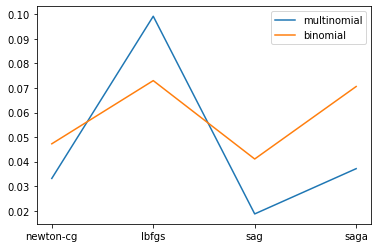

In [20]:
fig = plt.figure()
# Plot training duration
plt.plot(solvers, multinomial_train_time, label = 'multinomial')
plt.plot(solvers, binomial_train_time, label = 'binomial')
# Plot legend and figure
plt.legend()
plt.show()

Dans la suite nous utilisons le modèle ovr avec le solveur sag, car c'est le plus rapide et c'est l'un des plus précis.

In [21]:
opt_regressor_class = 'multinomial'
opt_regressor_solver = 'sag'

Détérminons le meilleur paramètre C:


In [22]:
C_values = np.linspace(1e-5, 1, 100)

# Initialize the optimal score
opt_score = 0
opt_regressor_C = 0

for C in C_values:
    # Create the model
    regressor = LogisticRegression(C = C, multi_class = opt_regressor_class, solver = opt_regressor_solver, random_state = 0, max_iter= 100_000)

    # Fit model to data
    regressor.fit(BaseApp, LabelApp)
    
    # Get score
    score = regressor.score(BaseTest, LabelTest)
    if score > opt_score:
        opt_score = score
        opt_regressor_C = C

print(f"Le meilleur paramètre C est : {opt_regressor_C:.3f}")

Le meilleur paramètre C est : 0.010


###  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [23]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Entrainer les deux modèles : 
* **regressor** : le modèle multinomial avec le solveur sag, mais avec la valeur par defaut du paramètre C
* **opt_regressor** : le modèle multinomial avec le solveur sag et le paramètre C optimale

In [24]:
# le modèle par default
regressor = LogisticRegression(max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)
regressor = regressor.fit(BaseApp, LabelApp)

# le modèle optimal
opt_regressor = LogisticRegression(C = opt_regressor_C, max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)
opt_regressor = opt_regressor.fit(BaseApp, LabelApp)

In [25]:
pred = regressor.predict(BaseTest)
opt_pred = opt_regressor.predict(BaseTest)
score = accuracy_score(LabelTest, pred)
opt_score = accuracy_score(LabelTest, opt_pred)

print(f"Le score du modèle par defaut est : {score * 100:.2f}%")
print(f"Le score du modèle optimale est : {opt_score * 100:.2f}%")

if opt_score > score:
    print("Le modèle avec les meilleurs paramètre est plus précis que celui implémenté par default.")
elif opt_score == score:
    print("Les deux modèles ont la même precision!!")
else: 
    print("Problème !")

Le score du modèle par defaut est : 35.71%
Le score du modèle optimale est : 42.86%
Le modèle avec les meilleurs paramètre est plus précis que celui implémenté par default.


Nous constatons que le modèle avec les meilleurs paramètre est plus précis que celui implémenté par default par scikit-learn.

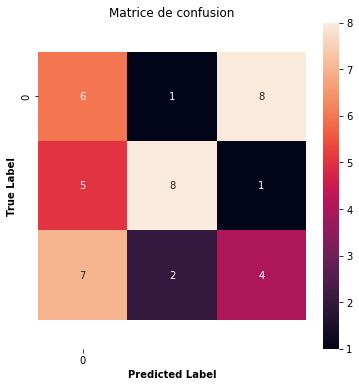

Accuracy sur base de test : 42.86%


In [26]:
def heatmap(pred, Label_Test):
    cm = confusion_matrix(Label_Test, pred)
    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(data=cm, fmt='.0f', xticklabels=np.unique(pred).size, yticklabels=np.unique(pred).size, annot = True, linewidths=0)
    ax.set_aspect("equal", "datalim")
    ax.set_ylabel("True Label", fontsize=10, weight = "bold")
    ax.set_xlabel("Predicted Label", fontsize = 10, weight = "bold")
    plt.title("Matrice de confusion")
    plt.show(fig)
    print(f"Accuracy sur base de test : {accuracy_score(Label_Test, pred)*100:.2f}%")

heatmap(opt_pred, LabelTest)

La matrice de confusion nous montre que le modèle confond entre les classes, ce qui est normal étant donnée une précision de 42.86%

Vérifions si le rescaling améliore-il la performance.

In [27]:
# rescale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

BaseApp_scaled = scaler.fit_transform(BaseApp)
BaseTest_scaled = scaler.transform(BaseTest)

In [28]:
# Creer le modèle optimal
opt_regressor = LogisticRegression(C = opt_regressor_C, max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)

# train on normal data
opt_regressor.fit(BaseApp, LabelApp)
pred = opt_regressor.predict(BaseTest)
score = accuracy_score(LabelTest, pred)

# Creer le modèle optimal
opt_regressor = LogisticRegression(C = opt_regressor_C, max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)

# train on scaled data
opt_regressor.fit(BaseApp_scaled, LabelApp)
pred = opt_regressor.predict(BaseTest_scaled)
score_scaled = accuracy_score(LabelTest, pred)


print(f"Le score du modèle : {score * 100:.2f}%")
print(f"Le score du modèle entrainé sur le jeu de données reduit : {score_scaled * 100:.2f}%")

if score_scaled > score:
    print("La normalisation améliore la performance.")
elif score_scaled == score:
    print("Les deux modèles ont la même performance.")
else: 
    print("La normalisation dégrade la performance ! Inattendu !!")

Le score du modèle : 42.86%
Le score du modèle entrainé sur le jeu de données reduit : 33.33%
La normalisation dégrade la performance ! Inattendu !!



# Partie II : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau

    1) Varier le noyau
    2) Varier le paramètre de régularisation.


In [29]:
from sklearn.svm import SVC

Détérminons le meilleur noyau

In [30]:
kernels = ['poly', 'rbf', 'sigmoid', 'linear',]

# Initialize the optimal score
opt_score = 0
opt_kernels = []

for kernel in kernels:
    svm = SVC(kernel= kernel)
    svm.fit(BaseApp, LabelApp)

    score = svm.score(BaseTest, LabelTest)
    print(f"score : {score*100:.2f}% --> kernel : {kernel}")

    if score >= opt_score:
        if score > opt_score:
            opt_kernels = []
        opt_kernels.append(kernel)
        opt_score = score

print("\n")
print(f"les meilleurs noyaux sont : {opt_kernels}")


score : 35.71% --> kernel : poly
score : 33.33% --> kernel : rbf
score : 35.71% --> kernel : sigmoid
score : 42.86% --> kernel : linear


les meilleurs noyaux sont : ['linear']


Nous avons trouvé que le meilleur noyau à utilisé est le noyau linéaire.

Cherchons maintenant le meilleur paramètre C pour le noyau linéaire.

In [31]:
opt_svm_kernel = 'linear'

In [32]:
C_values = np.linspace(1e-5, 1, 50)

# Initialize the optimal score
opt_score = 0
opt_svm_C = 0

for C in C_values:
    svm = SVC(C = C, kernel = opt_svm_kernel)
    svm.fit(BaseApp, LabelApp)

    score = svm.score(BaseTest, LabelTest)

    if score > opt_score:
        opt_score = score
        opt_svm_C = C

print(f"le meilleur paramètre C pour le noyau linéaire est : {opt_svm_C:.3f}")


le meilleur paramètre C pour le noyau linéaire est : 0.041


Comparons les deux modèles : 
* **svm** : le modèle svm linéaire avec le paramètre C par defaut de scikit-learn (C = 1).
* **opt_svm** : le modèle svm linéaire avec le paramètre C optimale qu'on vient de trouver.

In [33]:
# Parameter C by default ( C = 1)
svm = SVC(kernel = opt_svm_kernel)
svm.fit(BaseApp, LabelApp)
score = svm.score(BaseTest, LabelTest)

# Optimal parameter C
opt_svm = SVC(kernel = opt_svm_kernel, C = opt_svm_C)
opt_svm.fit(BaseApp, LabelApp)
opt_score = opt_svm.score(BaseTest, LabelTest)

if opt_score > score : 
    print("La précision du modèle a augmenté avec le paramètre C optimal.")
    print(f"{opt_score*100:.2f}% > {score*100:.2f}%")
elif opt_score == score:
    print("Les deux modèles ont la même précision.")
    print(f"{opt_score*100:.2f}% = {score*100:.2f}%")
else:
    print("Problème!")
    print(f"{opt_score*100:.2f}% < {score*100:.2f}%")

La précision du modèle a augmenté avec le paramètre C optimal.
47.62% > 42.86%


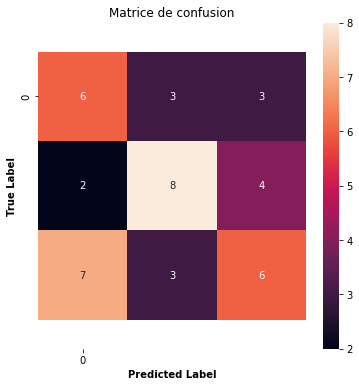

Accuracy sur base de test : 47.62%


In [34]:
pred = opt_svm.predict(BaseTest)
heatmap(LabelTest, pred)

### Approche non supervisée :  Classification spectrale 

 On peut aussi transposer à l'espace de Hilbert $\mathcal{H}$ des algos classiques de $\mathbb{R}^d$ comme la Classification spectrale.
 
 Réaliser une classification spectrale non supervisée sur les données. Interpréter les résultats 

In [35]:
from sklearn.cluster import SpectralClustering

In [36]:
BaseAll = np.concatenate([BaseApp, BaseTest])
LabelAll = np.concatenate([LabelApp, LabelTest])

clustering = SpectralClustering(n_clusters=3, random_state= 0, assign_labels= 'discretize')
clustering.fit(BaseAll)
y_pred =  clustering.labels_
score = accuracy_score(y_pred, LabelAll)
print(f"Le score du clustering est : {score* 100:.2f}%")

Le score du clustering est : 28.02%


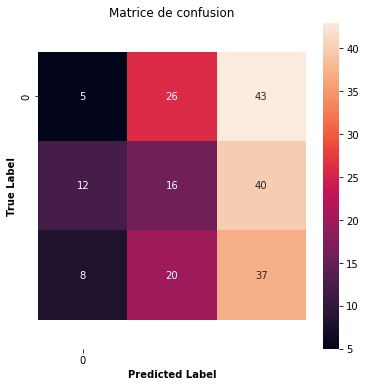

Accuracy sur base de test : 28.02%


In [37]:
heatmap(y_pred, LabelAll)

# Partie III : Apprentissage par ensemble 

## 1. Adaptive Boosting : AdaBoost 

Adaboost repose sur la sélection itérative de classifieur faible en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant. 

Réaliser une classification par adaboost et étudier 

In [38]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
# The regression model
opt_regressor = LogisticRegression(C = opt_regressor_C, solver= opt_regressor_solver, multi_class= opt_regressor_class)
opt_regressor.fit(BaseApp_scaled, LabelApp)
score = opt_regressor.score(BaseTest_scaled, LabelTest)

# Adaboost
clf = AdaBoostClassifier(base_estimator= opt_regressor ,n_estimators=100, random_state=0)
clf.fit(BaseApp_scaled, LabelApp)
ada_score = clf.score(BaseTest_scaled, LabelTest)


if ada_score > score : 
    print("AdaBoost a augmenté la précision du modèle de regression logistique.")
    print(f"{ada_score*100:.2f}% > {score*100:.2f}%")
elif ada_score == score:
    print("Les deux modèles ont la même précision.")
    print(f"{ada_score*100:.2f}% = {score*100:.2f}%")
else:
    print("AdaBoost a diminué la performance du modèle de regression logistique!")
    print(f"{ada_score*100:.2f}% < {score*100:.2f}%")

AdaBoost a augmenté la précision du modèle de regression logistique.
35.71% > 33.33%


In [40]:
# The regression model
opt_svm = SVC(C = opt_svm_C, kernel = opt_svm_kernel)
opt_svm.fit(BaseApp, LabelApp)
score = opt_svm.score(BaseTest, LabelTest)

# AdaBoost
clf = AdaBoostClassifier(base_estimator= opt_svm, algorithm='SAMME', n_estimators=100, random_state=0)
clf.fit(BaseApp, LabelApp)
ada_score = clf.score(BaseTest, LabelTest)

if ada_score > score : 
    print("AdaBoost a augmenté la précision du modèle SVC.")
    print(f"{ada_score*100:.2f}% > {score*100:.2f}%")
elif ada_score == score:
    print("Les deux modèles ont la même précision.")
    print(f"{ada_score*100:.2f}% = {score*100:.2f}%")
else:
    print("AdaBoost a diminué la performance du modèle SVC!")
    print(f"{ada_score*100:.2f}% < {score*100:.2f}%")

AdaBoost a diminué la performance du modèle SVC!
38.10% < 47.62%


## 2. Gradient Boosting

Le Gradient Boosting permet l'optimisation de fonctions de perte différentiables arbitraires. Il permet d'optimiser la fonction de perte de l'apprenant précédent en ajoutant un nouveau modèle adaptatif qui combine des apprenants faibles.

Etudier sur la fonction de perte et le taux d'apprentissage.

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

In [42]:
n_estimators_values = list(range(50,100))
lerning_rate_values = np.linspace(0.01, 1, 10)

stratified_folds = []

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(BaseAll, LabelAll):
    train_fold, test_fold = BaseAll[train_index], BaseAll[test_index]
    train_fold_labels, test_fold_labels = LabelAll[train_index], LabelAll[test_index]
    stratified_folds.append(
        {
            "train_fold": train_fold,
            "train_fold_labels": train_fold_labels,
            "test_fold": test_fold,
            "test_fold_labels": test_fold_labels
        }
    )


opt_score = 0
counter = 1
for n_estimators, lr in itertools.product(n_estimators_values, lerning_rate_values):
    scores = []
    for fold in stratified_folds:
        train_fold, train_fold_labels = fold['train_fold'], fold['train_fold_labels']
        test_fold, test_fold_labels = fold['test_fold'], fold['test_fold_labels']
        clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                        learning_rate=lr,
                                        max_depth=1).fit(train_fold, train_fold_labels)
        score = clf.score(test_fold, test_fold_labels)
        scores.append(score)
    
    mean_score = np.mean(scores)
    if mean_score > opt_score:
        opt_score = mean_score
        opt_n_estimators = n_estimators
        opt_lr = lr
        print(f"new optimal score : {mean_score*100:.2f}%")
        print(f"number of estimators : {opt_n_estimators}")
        print(f"learning rate : {opt_lr}")
        print()

new optimal score : 31.42%
number of estimators : 50
learning rate : 0.01

new optimal score : 34.77%
number of estimators : 50
learning rate : 0.12

new optimal score : 37.62%
number of estimators : 50
learning rate : 0.67

new optimal score : 37.63%
number of estimators : 52
learning rate : 0.67

new optimal score : 38.08%
number of estimators : 56
learning rate : 0.67

new optimal score : 38.10%
number of estimators : 68
learning rate : 0.67

new optimal score : 38.58%
number of estimators : 69
learning rate : 0.67



In [43]:
from xgboost import XGBClassifier

In [44]:
xgb_clf = XGBClassifier()
xgb_clf.fit(BaseApp, LabelApp)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [45]:
score = xgb_clf.score(BaseTest, LabelTest)
print(score)

0.3333333333333333


### Evaluation de la classification

Utiliser la validation croisée pour évaluer les résultats 

In [46]:
from sklearn.model_selection import cross_val_score

In [47]:
clf = GradientBoostingClassifier(n_estimators=opt_n_estimators, 
                                        learning_rate=opt_lr,
                                        max_depth=1)

scores = cross_val_score(clf, BaseAll, LabelAll, cv = 5)
score = np.mean(scores)

print(f"le score obtenu est : {score*100:.2f}%")

le score obtenu est : 38.58%


# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différents solveurs

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

activation_values = ['identity', 'logistic', 'tanh', 'relu']
solver_values = ['lbfgs', 'adam', 'sgd']
alpha_values = np.linspace(1e-6, 10, 200)

opt_score = 0
for activation, solver in itertools.product(activation_values, solver_values):
    clf = MLPClassifier(activation = activation, 
                        solver = solver, 
                        random_state=0, 
                        learning_rate = 'adaptive', 
                        max_iter=100_000_000).fit(BaseApp, LabelApp)
    score = clf.score(BaseTest, LabelTest)
    if score > opt_score:
        opt_score = score
        opt_activation = activation
        opt_solver = solver


opt_score = 0
for alpha in alpha_values:
    clf = MLPClassifier(activation = opt_activation, 
                        solver = opt_solver, 
                        alpha = alpha, 
                        random_state=0, 
                        learning_rate = 'adaptive', 
                        max_iter=100_000_000).fit(BaseApp, LabelApp)
    score = clf.score(BaseTest, LabelTest)
    if score > opt_score:
        opt_score = score
        opt_alpha = alpha

print(f"activation : {opt_activation}")
print(f"solver : {opt_solver}")
print(f"alpha : {opt_alpha}")

activation : identity
solver : adam
alpha : 5.778894894472362


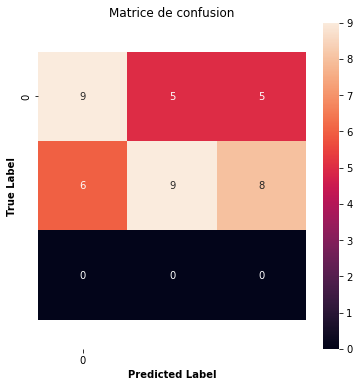

Accuracy sur base de test : 42.86%


In [49]:
clf = MLPClassifier(
    activation = opt_activation, 
    solver = opt_solver, 
    alpha = opt_alpha, 
    random_state=0, 
    learning_rate = 'adaptive', 
    max_iter=100_000_000
    )
clf.fit(BaseApp, LabelApp)
y_pred=clf.predict(BaseTest)
heatmap(LabelTest, y_pred)

# Partie V : Votre étude 




Réalisez votre propre étude par binôme :
- en modifiant les bases de test et/ou d'apprentissage c'est-à-dire en créant  votre propre base d'apprentissage et votre base de test à partir du corpus et des voix et bruits que vous aurez enregistrés
- en rajoutant davantage de classes (jusqu'à 13 ordres vocaux disponibles) 
- en utilisant d'autres méthodes de réduction de dimension des MFCC (ACP,t-SNE)
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport en pdf. 


**Paramètres pour enregistrements audio de vos voix perso:**

16 KHz, mono, 16 bits, format *.wav*

En faisant de la data augmentation, nous allons créer un plus grand jeu de données dans lequels :

* Nous supprimons les silences du début et de la fin de chaque fichier.
* Nous ajoutons du bruit gaussien au signal complet.
* Nous allons augmenter ou reduire le volume du signal complet.

Implémentons une fonction pour écouter les fichiers audio sur jupyter.

In [50]:
import IPython, json
def read_audio(audio, sr):
    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
            <script>
                if (!window.audioContext) {
                    window.audioContext = new AudioContext();
                    window.playAudio = function(audioChannels, sr) {
                        const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                        for (let [channel, data] of audioChannels.entries()) {
                            buffer.copyToChannel(Float32Array.from(data), channel);
                        }
                
                        const source = audioContext.createBufferSource();
                        source.buffer = buffer;
                        source.connect(audioContext.destination);
                        source.start();
                    }
                }
            </script>
            <button onclick="playAudio(%s, %s)">Listen to audio!</button>
        """ % (json.dumps(channels), sr))


### Transformations sur un seul fichier

In [51]:
from audiomentations import Compose, Trim, AddGaussianNoise, Gain

In [52]:
import math, random
import torchaudio
from torchaudio import transforms

In [53]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig[:1, :], sig[:1, :]])

        return ((resig, sr))

    # ----------------------------
    # Delete silence from beginning and end of the audio
    # ----------------------------
    @staticmethod
    def trim(aud):
        sig, sr = aud
        sig = Trim().apply(sig, sr)
        return sig, sr

    # ----------------------------
    # Add gaussian noise to the audio file
    # ----------------------------
    @staticmethod
    def add_noise(aud):
        sig, sr = aud
        noise_adder = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude= 0.02)])
        sig = noise_adder(sig, sr)
        return sig, sr

    # ----------------------------
    # Increase or decrease volume
    # ----------------------------
    @staticmethod
    def change_volume(aud):
        sig, sr = aud
        volume_adapter = Compose([Gain()])
        sig = volume_adapter(sig, sr)
        return sig, sr

    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

##### Supprimer le silence au début et à la fin du fichier audio

avant le trim: 
duration :  1.4048125


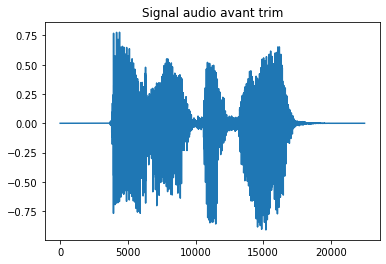

In [54]:
audio, sr = AudioUtil.open(filepath)
print("avant le trim: ")
print("duration : ", librosa.get_duration(audio, sr = sr))
plot_audio(audio, fig_title = "Signal audio avant trim")
read_audio(audio, sr)

après le trim: 
duration :  0.928


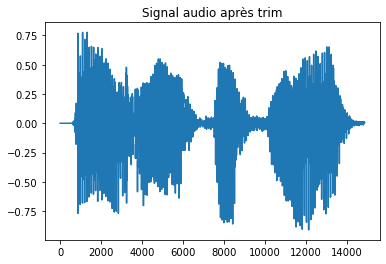

In [55]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))
print("après le trim: ")
print("duration : ", librosa.get_duration(audio, sr = sr))
plot_audio(audio, fig_title = "Signal audio après trim")
read_audio(audio, sr)


##### Ajouter du bruit gaussien au signal complet.

avant l'ajout du bruit gausien : 


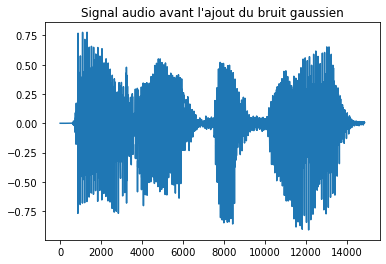

In [56]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))

print("avant l'ajout du bruit gausien : ")
plot_audio(audio, fig_title = "Signal audio avant l'ajout du bruit gaussien")
read_audio(audio, sr)

après l'ajout du bruit gausien : 


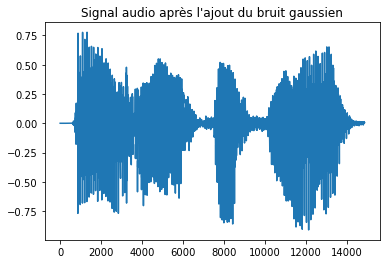

In [57]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))
audio, sr = AudioUtil.add_noise((audio, sr))

print("après l'ajout du bruit gausien : ")
plot_audio(audio, fig_title = "Signal audio après l'ajout du bruit gaussien")
read_audio(audio, sr)


##### Changer (augmenter ou reduire) le volume du signal.

avant le changement du volume : 


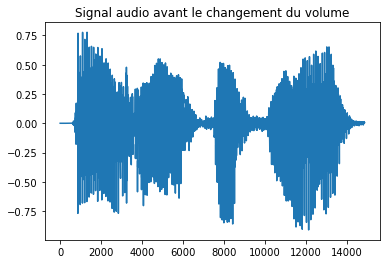

In [58]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))

print("avant le changement du volume : ")
plot_audio(audio, fig_title = "Signal audio avant le changement du volume")
read_audio(audio, sr)

après le changement du volume : 


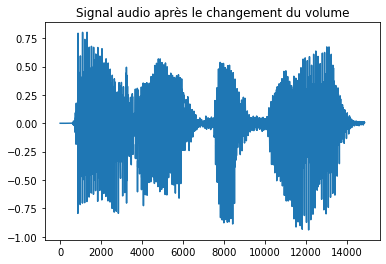

In [59]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))
audio, sr = AudioUtil.change_volume((audio, sr))

print("après le changement du volume : ")
plot_audio(audio, fig_title = "Signal audio après le changement du volume")
read_audio(audio, sr)

##### Suppression de la fin du fichier audio

Avant trancature : 


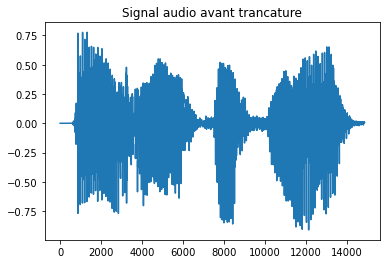

In [60]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))

print("Avant trancature : ")
plot_audio(audio, fig_title = "Signal audio avant trancature")
read_audio(audio, sr)

Après trancature : 


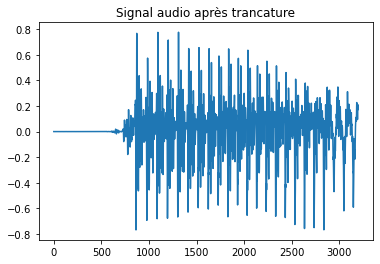

In [61]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.trim((audio, sr))
audio, sr = AudioUtil.pad_trunc((audio, sr), 200)

print("Après trancature : ")
plot_audio(audio, fig_title = "Signal audio après trancature")
read_audio(audio, sr)


##### Translation temporelle (horizontale)

Avant shift : 


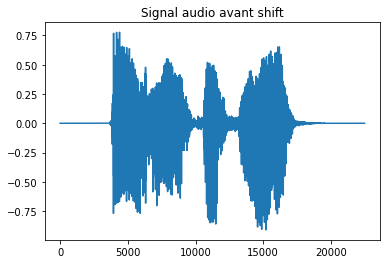

In [62]:
audio, sr = AudioUtil.open(filepath)

print("Avant shift : ")
plot_audio(audio, fig_title = "Signal audio avant shift")
read_audio(audio, sr)

Avant shift : 


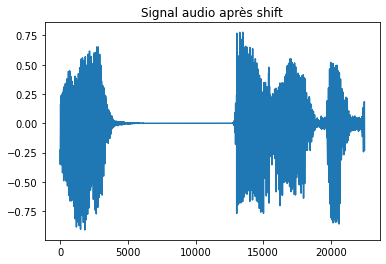

In [63]:
audio, sr = AudioUtil.open(filepath)
audio, sr = AudioUtil.time_shift((audio, sr), 1)

print("Avant shift : ")
plot_audio(audio, fig_title = "Signal audio après shift")
read_audio(audio, sr)

##### Transformer en spectre MEL

In [64]:
import librosa.display

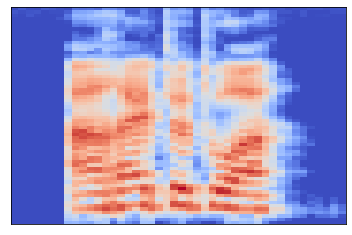

In [65]:
audio, sr = AudioUtil.open(filepath)
spec = AudioUtil.spectro_gram((audio, sr))
librosa.display.specshow(np.squeeze(spec.numpy()))
plt.show()

##### Masquer des bandes temporelle et frequentiel du spectre

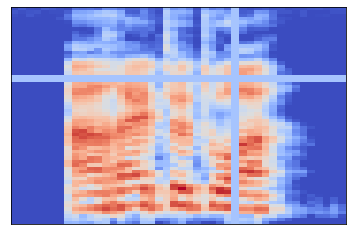

In [66]:
audio, sr = AudioUtil.open(filepath)
spec = AudioUtil.spectro_gram((audio, sr))
spec = AudioUtil.spectro_augment(spec, max_mask_pct= 0.2)
librosa.display.specshow(np.squeeze(spec.numpy()))
plt.show()

In [67]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class DroneDS(Dataset):
  def __init__(self, df):
    self.df = df
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    fpath = self.df.filepath.iloc[idx]
    # Get the Class ID
    labelId = self.df.labelId.iloc[idx]

    aud = AudioUtil.open(fpath)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    t_aud = AudioUtil.trim(reaud)
    gain_aud = AudioUtil.change_volume(t_aud)
    noise_aud = AudioUtil.add_noise(gain_aud)


    rechan = AudioUtil.rechannel(noise_aud, self.channel)
    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, labelId

In [68]:
aug_datapath = join(".", "aug_data")

train_path = join(aug_datapath, "train")
test_path = join(aug_datapath, "test")
aug_train_path = join(aug_datapath, "aug_train")

os.makedirs(train_path, exist_ok= True)
os.makedirs(test_path, exist_ok= True)
os.makedirs(aug_train_path, exist_ok= True)

In [69]:
def get_dataframe(datapath):
    
    # Get file names and sort them in order to have the same order
    # no matter what OS you are using
    files = sorted(listdir(datapath))

    # Initiate the data dictionnary
    df = {
        "filename" : [],
        "filepath" : [],
        "noise": [],
        "label": [],
        "labelId": []
    }

    # Determine the label, filepath and whether the file contain noise of not
    for fname in files:
        fpath = join(datapath, fname)
        noise = "bruite" in fname
        name, _ = fname.split('.')
        _, label = name.split('_')
        
        df["filename"].append(fname)
        df["filepath"].append(fpath)
        df["noise"].append(noise)
        df["label"].append(label)
        df["labelId"].append(all_classes.index(label))

    df = pd.DataFrame(df)
    return df

def stratified_split(datapath, test_pct = 0.2, keep_classes = None):
    
    dataframe = get_dataframe(datapath)

    if keep_classes:
        dataframe = dataframe.loc[dataframe.label.isin(keep_classes)]
        
    sss = StratifiedShuffleSplit(n_splits=1, test_size= test_pct, random_state=0)
    for train_index, test_index in sss.split(dataframe.filename, dataframe.labelId):
        # just to get the train_index and test_index lists
        train_indices = np.array(train_index)
        test_indices = np.array(test_index)
    train_df, test_df = dataframe.iloc[train_indices], dataframe.iloc[test_indices]
    return train_df, test_df

In [70]:
train_df, test_df = stratified_split(datapath)
train_df.head()

,filename,filepath,noise,label,labelId
694,b1amine_gauche.wav,.\data\b1amine_gauche.wav,False,gauche,3
204,Espagne2_arretetoi.wav,.\data\Espagne2_arretetoi.wav,False,arretetoi,7
614,T03_faisunflip.wav,.\data\T03_faisunflip.wav,False,faisunflip,11
772,bruite-T02_plushaut.wav,.\data\bruite-T02_plushaut.wav,True,plushaut,5
591,T01_plushaut.wav,.\data\T01_plushaut.wav,False,plushaut,5


In [71]:
train_ds = DroneDS(train_df)
test_ds = DroneDS(test_df)

In [72]:
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [73]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Forth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=13)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [75]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  Losses = []  
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    Losses.append(avg_loss)
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  return Losses
  
num_epochs= 300   # Just for demo, adjust this higher.
Losses = training(myModel, train_dl, num_epochs)
torch.save(myModel, "model.pkl")

Epoch: 0, Loss: 2.52, Accuracy: 0.11
Epoch: 1, Loss: 2.50, Accuracy: 0.12
Epoch: 2, Loss: 2.48, Accuracy: 0.12
Epoch: 3, Loss: 2.48, Accuracy: 0.13
Epoch: 4, Loss: 2.47, Accuracy: 0.13
Epoch: 5, Loss: 2.46, Accuracy: 0.12
Epoch: 6, Loss: 2.43, Accuracy: 0.15
Epoch: 7, Loss: 2.41, Accuracy: 0.15
Epoch: 8, Loss: 2.41, Accuracy: 0.14
Epoch: 9, Loss: 2.41, Accuracy: 0.16
Epoch: 10, Loss: 2.37, Accuracy: 0.22
Epoch: 11, Loss: 2.35, Accuracy: 0.17
Epoch: 12, Loss: 2.32, Accuracy: 0.19
Epoch: 13, Loss: 2.33, Accuracy: 0.20
Epoch: 14, Loss: 2.28, Accuracy: 0.22
Epoch: 15, Loss: 2.23, Accuracy: 0.23
Epoch: 16, Loss: 2.23, Accuracy: 0.24
Epoch: 17, Loss: 2.17, Accuracy: 0.26
Epoch: 18, Loss: 2.18, Accuracy: 0.24
Epoch: 19, Loss: 2.14, Accuracy: 0.30
Epoch: 20, Loss: 2.04, Accuracy: 0.30
Epoch: 21, Loss: 2.00, Accuracy: 0.33
Epoch: 22, Loss: 1.95, Accuracy: 0.34
Epoch: 23, Loss: 1.97, Accuracy: 0.34
Epoch: 24, Loss: 1.90, Accuracy: 0.38
Epoch: 25, Loss: 1.83, Accuracy: 0.42
Epoch: 26, Loss: 1.76,

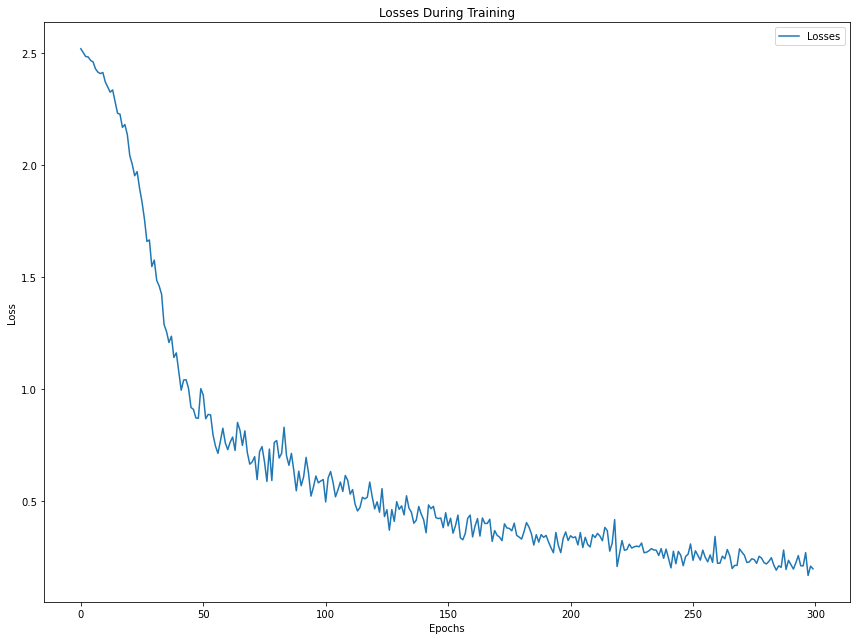

In [76]:
plt.figure(figsize=(12, 9))
plt.title("Losses During Training")
plt.plot(Losses, label="Losses")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig('Losses.png')  
plt.show()

In [74]:
Model = torch.load(f"model.pkl")

In [76]:
def inference(model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc*100:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(Model, test_dl)

Accuracy: 7.30, Total items: 178


Making and plotting the t-SNE embeddings

In [79]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [80]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data

all_json = dict()
tnse_embeddings = []
perplexities = [2, 5, 30, 50, 100]
iterations = [250, 500, 1000, 2000, 5000]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        tnse_wavenet = get_scaled_tsne_embeddings(BaseApp,
                                                  perplexity,
                                                  iteration)
        tnse_embeddings.append(tnse_wavenet)
        wavenet_key = 'tsnewavenet{}{}'.format(i, j) 
        all_json[wavenet_key] = transform_numpy_to_json(tnse_wavenet)

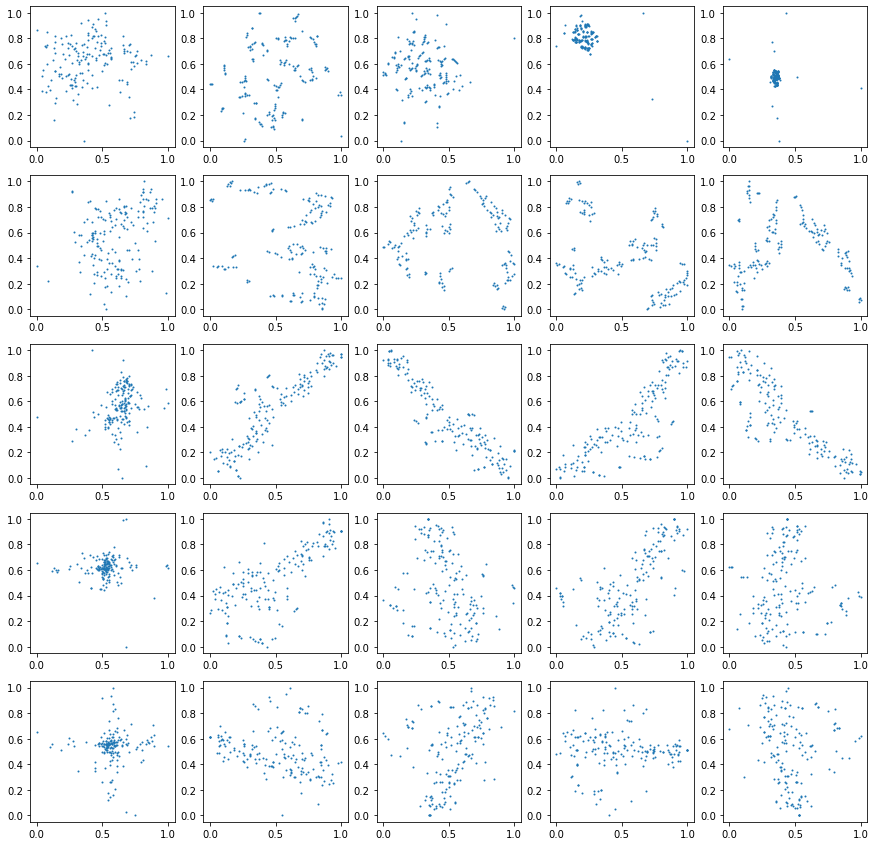

In [81]:
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(15, 15))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(tnse_embeddings[current_plot].T[0], 
                    tnse_embeddings[current_plot].T[1], 
                    s=1)
plt.show()

Here is the code to make and plot the UMAP embeddings

In [82]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

umap_embeddings = []
neighbours = [5, 10, 15, 30, 50]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        umap_wavenet = get_scaled_umap_embeddings(BaseApp,
                                                  neighbour,
                                                  distance)
        umap_embeddings.append(umap_wavenet)
        wavenet_key = 'umapwavenet{}{}'.format(i, j)
        all_json[wavenet_key] = transform_numpy_to_json(umap_wavenet)

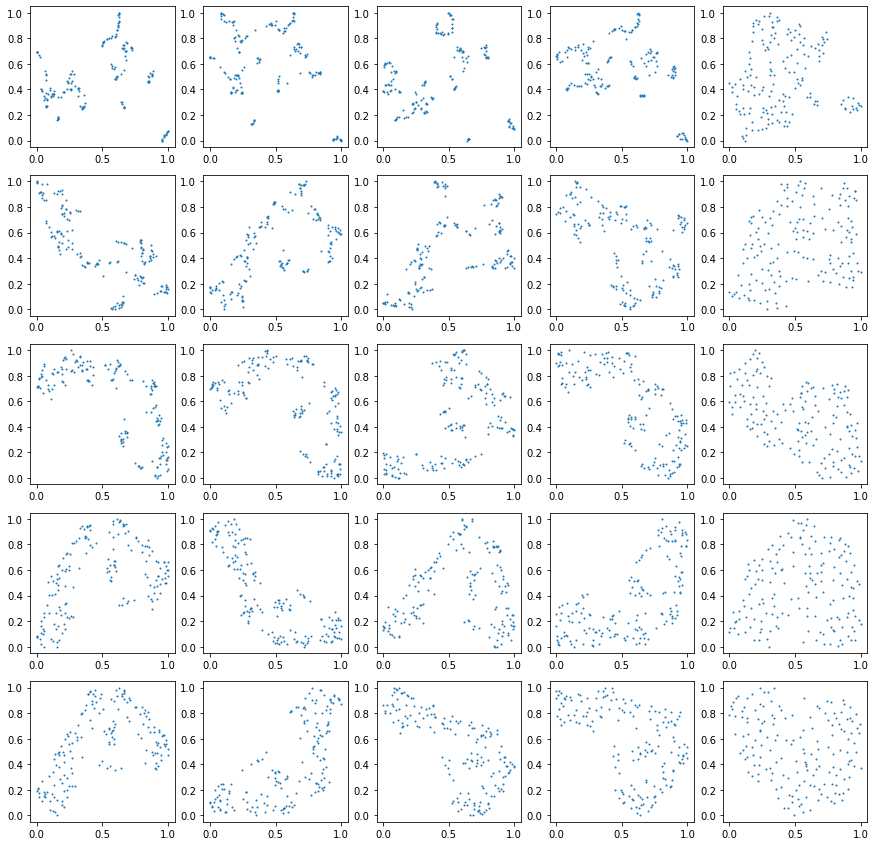

In [85]:
fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(15, 15))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(umap_embeddings[current_plot].T[0], 
                    umap_embeddings[current_plot].T[1], 
                    s=1)
plt.show()

And last but not least, the PCA plots

In [83]:
def get_pca(features):
    pca = PCA(n_components=2)
    transformed = pca.fit(features).transform(features)
    scaler = MinMaxScaler()
    scaler.fit(transformed)
    return scaler.transform(transformed)

pca_mfcc = get_pca(BaseApp)

mfcc_key = 'pcamfcc'

all_json[mfcc_key] = transform_numpy_to_json(pca_mfcc)

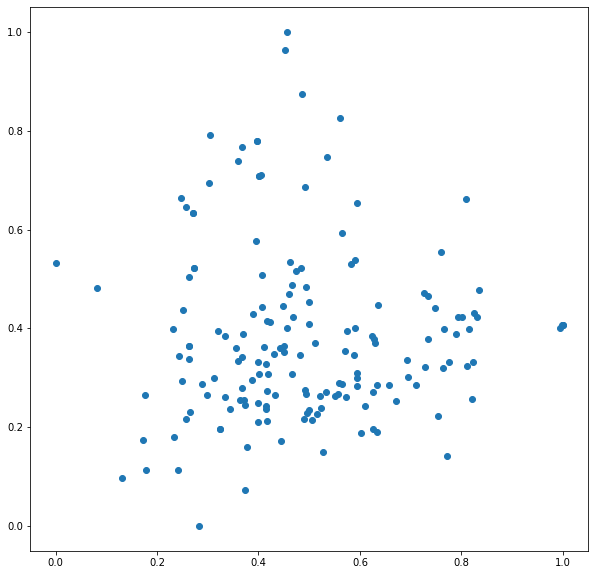

In [87]:
plt.figure(figsize=(10, 10))
_ = plt.scatter(pca_mfcc.T[0],
                pca_mfcc.T[1])
plt.show()

Its a bit weird but saving the data in this manner allows for synchrnous loading in a html file

In [88]:
json_name = "data.json"
json_string = "d = '" + json.dumps(all_json) + "'"
with open(json_name, 'w') as json_file:
    json_file.write(json_string)